## Manual Data Annotation

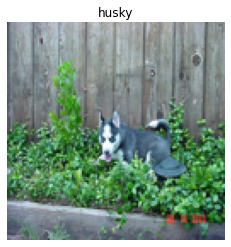

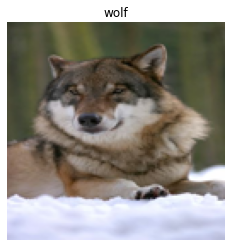

In [4]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define dataset path and categories
data_dir = r"E:\Programming\Machine Learning\Assignments\Pattern_Lab1\data\train"
categories = ["husky", "wolf"]
image_size = (128, 128)  # Resize images to a fixed size

dataset = []
labels = []

# Define augmentation functions
def random_rotation(image):
    return image.rotate(random.uniform(-30, 30)) #rotation is + or - 30 degrees

def random_flip(image):
    if random.random() > 0.5:  # 50% chance to flip
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

def random_crop(image, output_size):
    """Randomly crop an image and resize it back to the original size"""
    width, height = image.size
    left = random.randint(0, width // 4)
    top = random.randint(0, height // 4)
    right = width - random.randint(0, width // 4)
    bottom = height - random.randint(0, height // 4)
    return image.crop((left, top, right, bottom)).resize(output_size)

for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    img_files = os.listdir(category_path)
    
    # Select a random image from the category and display it FOR TESTING, CAN REMOVE THIS PART AND THE PLT
    random_img = random.choice(img_files)
    img_path = os.path.join(category_path, random_img)
    img = Image.open(img_path).convert("RGB").resize(image_size)

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")

    # Load all images into dataset
    for img_name in img_files:
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path).convert("RGB").resize(image_size)
        dataset.append(np.array(img))  # Convert image to NumPy array
        labels.append(label)  # Assign label
        # Augmented Images (Apply transformations randomly)
        for _ in range(2):  # Adding two augmented versions per image
            aug_img = random_rotation(random_flip(random_crop(img, image_size)))
            dataset.append(np.array(aug_img))
            labels.append(label)




In [5]:
# Convert lists to NumPy arrays
dataset = np.array(dataset, dtype=np.float32) / 255.0  # Normalize pixel values
labels = np.array(labels)

# Shuffle and split dataset (80-20) WE CAN CHANGE THE SPLIT AS WE WANT
indices = list(range(len(dataset)))
random.shuffle(indices)
split_idx = int(0.8 * len(dataset))

train_data, val_data = dataset[:split_idx], dataset[split_idx:]
train_labels, val_labels = labels[:split_idx], labels[split_idx:]

plt.show()  # Show the randomly selected images

print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}")

Training set size: 192, Validation set size: 48


# Neural Networks Approach

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt


In [7]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary, 0=husky , 1=wolf
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
# Augmentation & Preprocessing for training and validation (using validation_split)
image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of training data for validation
)

### Data Loading and Splitting

In [9]:
# Define image shape and batch size
image_shape = (150,150,3) 
batch_size = 16 



# Define directories
train_dir = r"E:\Programming\Machine Learning\Assignments\Pattern_Lab1\data\train"
test_dir = r"E:\Programming\Machine Learning\Assignments\Pattern_Lab1\data\test"

# Training data generator (excluding validation data)
train_generator = image_gen.flow_from_directory(
    train_dir, 
    target_size=image_shape[:2], 
    batch_size=batch_size, 
    class_mode='binary', 
    subset='training'  # Using only training data
)

# Validation data generator
validation_generator = image_gen.flow_from_directory(
    train_dir, 
    target_size=image_shape[:2], 
    batch_size=batch_size, 
    class_mode='binary', 
    subset='validation'  # Using only validation data
)

# Test data generator (for final predictions)
test_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
    test_dir, 
    target_size=image_shape[:2], 
    batch_size=batch_size, 
    class_mode='binary',
    shuffle=False  # Ensure test images are not shuffled for consistent results
)

Found 64 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


### Verifying Data Loading & Augmentation

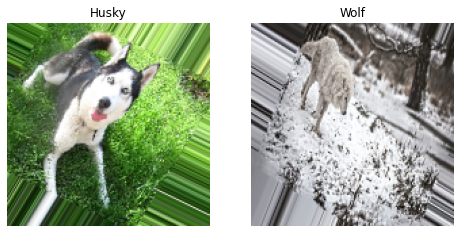

In [10]:
husky_img, wolf_img = None, None

for i in range(len(train_generator.filepaths)):  
    img, label = train_generator.next() 

    if label[0] == 0 and husky_img is None:  # First Husky image
        husky_img = img[0]
    elif label[0] == 1 and wolf_img is None:  # First Wolf image
        wolf_img = img[0]
    
    if husky_img is not None and wolf_img is not None:  
        break 
    
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Husky Image
axes[0].imshow(husky_img)
axes[0].set_title("Husky")
axes[0].axis('off')

# Wolf Image
axes[1].imshow(wolf_img)
axes[1].set_title("Wolf")
axes[1].axis('off')

plt.show()

### Training The Model

In [11]:
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
4/4 [==============================] - 6s 740ms/step - loss: 0.7939 - accuracy: 0.4531 - val_loss: 0.6695 - val_accuracy: 0.6875
Epoch 2/10
4/4 [==============================] - 3s 634ms/step - loss: 0.6442 - accuracy: 0.6094 - val_loss: 0.5940 - val_accuracy: 0.9375
Epoch 3/10
4/4 [==============================] - 3s 638ms/step - loss: 0.4878 - accuracy: 0.9062 - val_loss: 0.3808 - val_accuracy: 0.8750
Epoch 4/10
4/4 [==============================] - 2s 569ms/step - loss: 0.3577 - accuracy: 0.8906 - val_loss: 0.4003 - val_accuracy: 0.6875
Epoch 5/10
4/4 [==============================] - 2s 614ms/step - loss: 0.2368 - accuracy: 0.9219 - val_loss: 0.3755 - val_accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 2s 601ms/step - loss: 0.3201 - accuracy: 0.8906 - val_loss: 0.1601 - val_accuracy: 0.9375
Epoch 7/10
4/4 [==============================] - 2s 593ms/step - loss: 0.2845 - accuracy: 0.8906 - val_loss: 0.2563 - val_accuracy: 0.8750
Epoch 8/10
4/4 [====

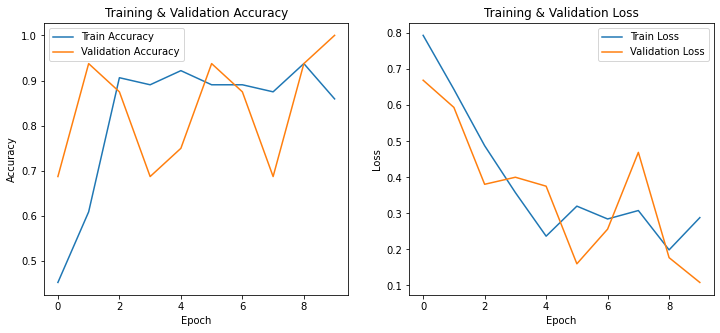

In [12]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Print Predictions
print("Predicted Classes:", predicted_classes.flatten())

Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


### Displaying Results

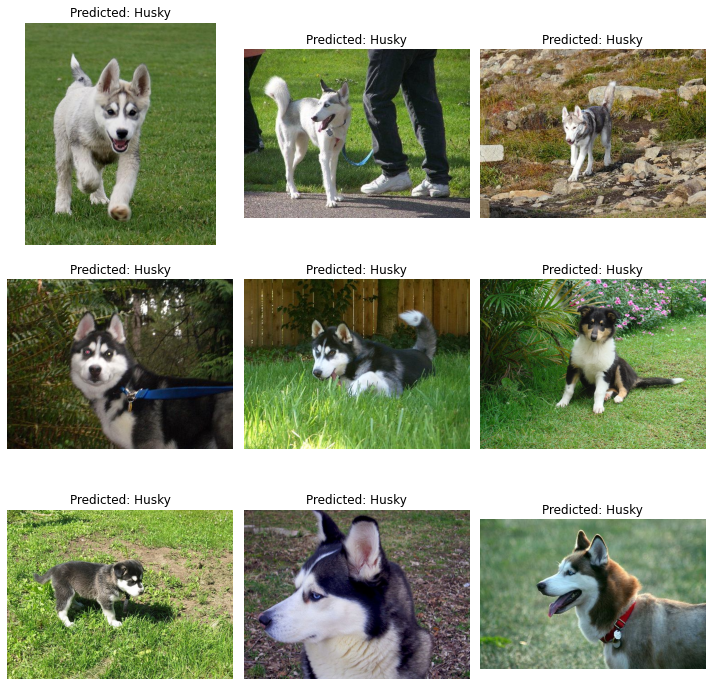

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid for displaying images
axes = axes.ravel()
tests = test_generator
for i in range(9):  # Show 9 sample test images
    img = plt.imread(test_generator.filepaths[i])  # Read image
    axes[i].imshow(img)
    label = "Wolf" if predicted_classes[i] == 1 else "Husky"
    axes[i].set_title(f"Predicted: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

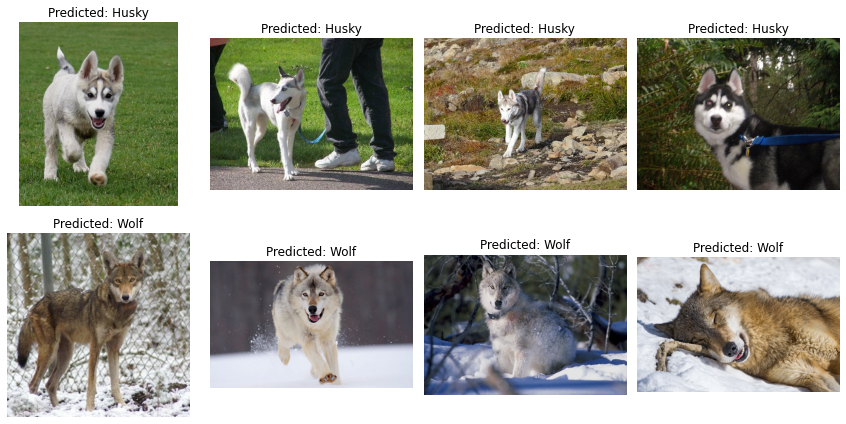

In [15]:
filepaths = np.array(test_generator.filepaths)
true_labels = np.array(test_generator.classes)  # Actual class labels

# Separate correctly classified huskies and wolves
husky_indices = np.where(predicted_classes == 0)[0]  # Model predicted 'husky'
wolf_indices = np.where(predicted_classes == 1)[0]  # Model predicted 'wolf'

# Select at most 4 images from each class (adjust based on availability)
num_samples = min(len(husky_indices), len(wolf_indices), 4)

husky_samples = husky_indices[:num_samples]  # First 'num_samples' husky images
wolf_samples = wolf_indices[:num_samples]  # First 'num_samples' wolf images

# Merge both classes for display
selected_indices = np.concatenate([husky_samples, wolf_samples])
selected_filepaths = filepaths[selected_indices]
selected_labels = predicted_classes[selected_indices]

# Display Images
fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))  # 2 rows (huskies & wolves), dynamic columns
axes = axes.ravel()

for i, idx in enumerate(selected_indices):
    img = plt.imread(selected_filepaths[i])  # Read image
    label = "Wolf" if selected_labels[i] == 1 else "Husky"
    
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Testing

In [48]:
def preprocess_images(test_path):
    test_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
        test_path, 
        target_size=image_shape[:2], 
        batch_size=batch_size, 
        class_mode='binary',
        shuffle=False  # Ensure test images are not shuffled for consistent results
    )
    
    X_test, y_test = [], []

    # Loop through all batches
    for _ in range(len(test_generator)):  # Number of batches
        img_batch, label_batch = test_generator.next()
        X_test.append(img_batch)
        y_test.append(label_batch)

    # Convert lists to NumPy arrays
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    return X_test, y_test
    
def make_predictions(X_test, model):
    # Get predicted probabilities
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels (0 or 1)
    y_pred = (y_pred_probs > 0.5).astype(int)  # Thresholding at 0.5 for binary classification

    return y_pred


def accuracy_score(y_test, y_pred):
    correct_predictions = 0 
    for i in range(len(y_pred)):
        correct_predictions += y_pred[i]==y_test[i]

    total_samples = len(y_test)  
    accuracy = correct_predictions / total_samples  # Compute accuracy
    
    return float(accuracy) * 100 

In [ ]:
test_path = ""

X_test,y_test = preprocess_images(test_path)

y_pred = make_predictions(X_test,model)

print(accuracy_score(y_test,y_pred))

Found 20 images belonging to 2 classes.
95.0
